In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import mean_squared_log_error



In [2]:
plt.style.use('seaborn')

## 1. Define Goal

The goal for this week’s project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather

## 2. Read Data

In [3]:
df = pd.read_csv('./data/train.csv', parse_dates=['datetime'])

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.shape

(10886, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Define X and y

In [8]:
y = df['count']
cols = ['datetime','temp','weather','season','holiday','workingday','windspeed']
X = df[cols]

## 3. Train-Test-Split

In [9]:
(X_train, X_test, y_train, y_test) = train_test_split(X,y)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 7), (2722, 7), (8164,), (2722,))

In [11]:
X_train.head()

,datetime,temp,weather,season,holiday,workingday,windspeed
1852,2011-05-04 02:00:00,20.50,3,2,0,1,19.0012
10591,2012-12-07 17:00:00,15.58,2,4,0,1,0.0000
8618,2012-08-01 11:00:00,31.16,1,3,0,1,6.0032
1657,2011-04-14 23:00:00,18.86,1,2,0,1,7.0015
129,2011-01-06 15:00:00,11.48,1,1,0,1,0.0000


## 4. Data Exploration

## 5. Feature Engineering

In [12]:
# splitting the datetime column into year, month, weekday and hour

def datetime_split(df):
    dummy = df.copy()
    dummy['year'] = df['datetime'].dt.year
    dummy['month'] = df['datetime'].dt.month
    dummy['weekday'] = df['datetime'].dt.weekday
    dummy['hour'] = df['datetime'].dt.hour
    return dummy

# create a FunctionTransformer object which executes the datetime_split() function

ft = FunctionTransformer(datetime_split)

In [13]:
ct = ColumnTransformer([
        ('do nothing', 'passthrough', ['year','month','weekday','hour','temp','weather','season','holiday','workingday','windspeed'])
])

In [14]:
fe = make_pipeline(
    ft,
    ct
)

In [29]:
fe.fit(X_train)
X_train_trans = fe.transform(X_train)
X_train_trans.shape

(8164, 10)

## 6. Define Model

In [15]:
model = make_pipeline(
    fe,
    RandomForestRegressor(max_depth=12)
)

In [16]:
cv_results = cross_validate(
    estimator=model,             # the model you want to evaluate 
    X=X_train,                     # the training input data 
    y=y_train,                     # the training output data  
    cv=5,                    # number of cross validation datasets 
    scoring='neg_mean_squared_log_error',               # evaluation metric 
    return_train_score=True,   # return both the score on the training and the cross validated data
    n_jobs=1                   # n_jobs = -1 for using all your processores
)

In [17]:
# show results in dataframe
df_cv = pd.DataFrame(cv_results)
df_cv

,fit_time,score_time,test_score,train_score
0,0.977197,0.024093,-0.123862,-0.048504
1,0.957483,0.024279,-0.120539,-0.048047
2,0.951233,0.024462,-0.125478,-0.046969
3,0.916243,0.024241,-0.120746,-0.048844
4,0.881567,0.025167,-0.129441,-0.045085


In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function datetime_split at 0x7fcec1462ca0>)),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('do nothing',
                                                                   'passthrough',
                                                                   ['year',
                                                                    'month',
                                                                    'weekday',
                                                                    'hour',
                                                                    'temp',
                                                                    'weather',
                                                                    'season',
                                                 

## 7. Use model on Test Data

In [19]:
y_pred = model.predict(X_test)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function datetime_split at 0x7fcec1462ca0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('do nothing', 'passthrough',
                                                  ['year', 'month', 'weekday',
                                                   'hour', 'temp', 'weather',
                                                   'season', 'holiday',
                                                   'workingday',
                                                   'windspeed'])]))])

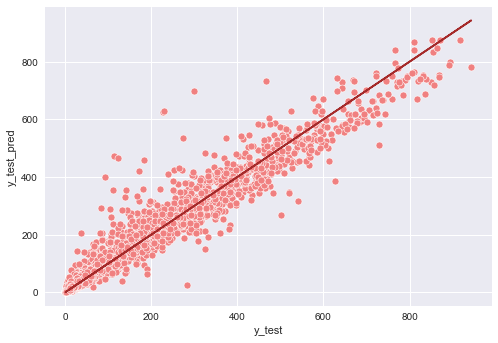

In [31]:
sns.scatterplot(x=y_test,y=y_pred, color='lightcoral')
plt.plot(y_test, y_test, color='brown')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

plt.savefig('./output/randomforestreg_res.jpg')

## 8. Use Model on Kaggle Test Data

In [21]:
kaggle = pd.read_csv('./data/test.csv', parse_dates=['datetime'])
kaggle.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [22]:
kaggle_X = kaggle[cols]
kaggle_y_pred = model.predict(kaggle_X)

In [23]:
output = pd.DataFrame({'datetime': kaggle.datetime, 'count': kaggle_y_pred})
output.to_csv('./output/kaggle_bike_submission_randomforest.csv', index=False)